# Bayesian Hierarchical Modeling
---

**Research Question**: How do unobserved latent variables, injury rates and score fluctuations (change in score based
on players on or off the court), influence the observed performance rate (win rates and points) of
the NBA teams? Can we gain insights into the relationship between injuries, score fluctuations,
and team performance?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

!pip install pymc==5.10.0
import pymc as pm
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.INFO)


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
games = pd.read_csv('/work/20231129-000846/games.csv')
games_details = pd.read_csv('/work/20231129-000846/games_details.csv')
ranking = pd.read_csv('/work/20231129-000846/ranking.csv')
teams = pd.read_csv('/work/20231129-000846/teams.csv')

/tmp/ipykernel_1027/2437426760.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv('/work/20231129-000846/games_details.csv')


In [ ]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [ ]:
games_details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [ ]:
# cleaning up season_id in ranking

season_id = ranking['SEASON_ID']
seasons = []
for s in season_id:
    seasons.append(int(str(s)[1:]))
ranking['SEASON_ID'] = seasons

# merging games and games_details

games_merged = games_details.merge(games, left_on = "GAME_ID", right_on = "GAME_ID", how = "inner")
games_merged

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669555,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,NaN,19,...,21.0,40.0,1610612743,106.0,0.532,0.615,0.471,25.0,34.0,0
669556,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,NaN,23,...,21.0,40.0,1610612743,106.0,0.532,0.615,0.471,25.0,34.0,0
669557,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,NaN,15,...,21.0,40.0,1610612743,106.0,0.532,0.615,0.471,25.0,34.0,0
669558,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,NaN,19,...,21.0,40.0,1610612743,106.0,0.532,0.615,0.471,25.0,34.0,0


In [ ]:
ranking.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,2022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,2022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,2022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,2022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,2022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


In [ ]:
# doing bayesian modeling for each season
def game_details_season(season):
    df = games_merged[games_merged["SEASON"] == season]
    df = df.drop(columns = ['COMMENT', 'NICKNAME', 'TEAM_ABBREVIATION', 'GAME_STATUS_TEXT', 'SEASON', 'TEAM_CITY', 'PLAYER_NAME', 'PLUS_MINUS'])
    return df

def ranking_season(season):
    df = ranking[ranking['SEASON_ID'] == season]
    return df

def bayesian_model(seasons):
    samples = {}
    for season in seasons:
        df = game_details_season(season)
        curr_ranking = ranking[ranking['SEASON_ID'] == season]

        normal_mu = [10, 10]
        normal_sigma = [6, 8]


        with pm.Model() as curr_model:
            I = pm.Bernoulli("I", 0.25, shape = len(df['TEAM_ID'].value_counts())) # 0 or 1 injury per team

            q = pm.Normal("q", mu = normal_mu, sigma = normal_sigma, shape = 2) # distribution of score fluctuation 

            P = pm.Poisson("P", mu = q[I], observed = df.groupby('TEAM_ID')['PTS'].mean()) # avg points per team 

            X = pm.Beta('X', alpha = q[I], beta = 10, observed = curr_ranking.groupby('TEAM_ID')['W_PCT'].mean()) # win rate per team based on score fluc. and avg win rate

            trace = pm.sample(1000, tune = 1000, return_inferencedata = False)

        samples[season] = trace['q']

    return samples

In [ ]:
desired_seasons = [2003, 2021]


samples = bayesian_model(desired_seasons)
samples

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [I]
>NUTS: [q]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [I]
>NUTS: [q]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


{2003: array([[ 8.81355261,  8.76434034],
        [ 8.54397085,  9.81766381],
        [ 9.03172239,  9.58917184],
        ...,
        [ 9.08551725,  9.51422005],
        [ 8.86878955, 10.45597265],
        [ 8.93513211, 10.51378534]]),
 2021: array([[ 9.18670858, 13.55731685],
        [ 9.22857239, 11.16044218],
        [ 9.50846423, 12.23606322],
        ...,
        [ 9.36359016,  8.94010676],
        [ 9.42573848,  9.82096126],
        [ 8.73055093, 11.91541131]])}

The score fluctuation varies more when there is an injury on the team (the y-axis), and less variation in the plus_minus when there is no injury on the team (x-axis, q0)

In [ ]:
# Calculate the median score fluctuation per season if a team is injured or not

for season in desired_seasons:
    print(f"{season}, Uninjured (q0): {np.median(samples[season][:, 0])}, Injured (q1): {np.median(samples[season][:, 1])}")

2003, Uninjured (q0): 8.719547561855169, Injured (q1): 8.818698873545376
2021, Uninjured (q0): 9.727016589549532, Injured (q1): 9.691724730814807


Despite more variance in the score fluctuation for teams with a serious injury, when using median, teams who did not have a serious injury had a higher score fluctuation average for all the seasons.

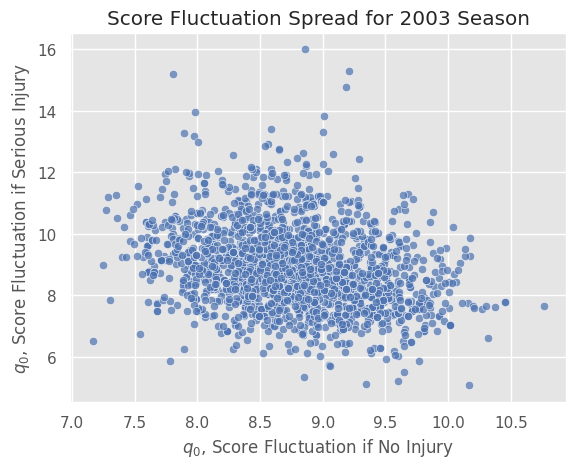

In [ ]:
# Plotting out scatter plots for 2003 Year
sns.scatterplot(x = samples[2003][:, 0], y = samples[2003][:, 1], c = "b", alpha = 0.7)
plt.xlabel("$q_0$, Score Fluctuation if No Injury")
plt.ylabel("$q_0$, Score Fluctuation if Serious Injury")
plt.title("Score Fluctuation Spread for 2003 Season");

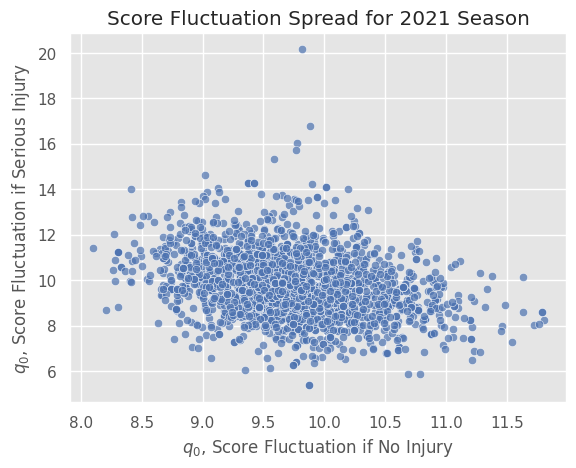

In [ ]:
# Plotting out scatter plots for 2021 Year
sns.scatterplot(x = samples[2021][:, 0], y = samples[2021][:, 1], c = "b", alpha = 0.7)
plt.xlabel("$q_0$, Score Fluctuation if No Injury")
plt.ylabel("$q_0$, Score Fluctuation if Serious Injury")
plt.title("Score Fluctuation Spread for 2021 Season");

In [ ]:
# quantifying uncertainty by calculating credible interval for 2003, using a 95% credible interval

q0_2003 = np.sort(samples[2003][:, 0])
q1_2003 = np.sort(samples[2003][:, 1])

q0_2003_lower = np.percentile(q0_2003, 2.5)
q0_2003_upper = np.percentile(q0_2003, 97.5)

q1_2003_lower = np.percentile(q1_2003, 2.5)
q1_2003_upper = np.percentile(q1_2003, 97.5)

print(f"2003, q0 95% Credible Interval for no significant injuries, Lower = {q0_2003_lower}, Upper = {q0_2003_upper}")
print(f"2003, q1 95% Credible Interval for significant injuries, Lower = {q1_2003_lower}, Upper = {q1_2003_upper}")

2003, q0 95% Credible Interval for no significant injuries, Lower = 7.658138295445255, Upper = 9.871901900705105
2003, q1 95% Credible Interval for significant injuries, Lower = 6.72672289871175, Upper = 11.817540946520992


In [ ]:
# quantifying uncertainty by calculating credible interval for 2021, using a 95% credible interval

q0_2021 = np.sort(samples[2021][:, 0])
q1_2021 = np.sort(samples[2021][:, 1])

q0_2021_lower = np.percentile(q0_2021, 2.5)
q0_2021_upper = np.percentile(q0_2021, 97.5)

q1_2021_lower = np.percentile(q1_2021, 2.5)
q1_2021_upper = np.percentile(q1_2021, 97.5)

print(f"2021, q0 95% Credible Interval for no significant injuries, Lower = {q0_2021_lower}, Upper = {q0_2021_upper}")
print(f"2021, q1 95% Credible Interval for significant injuries, Lower = {q1_2021_lower}, Upper = {q1_2021_upper}")

2021, q0 95% Credible Interval for no significant injuries, Lower = 8.691004311102722, Upper = 10.954120632710646
2021, q1 95% Credible Interval for significant injuries, Lower = 7.187528650025568, Upper = 12.848357855007318


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dab229b9-66f6-4eb3-b5aa-92c8de1aae4e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>